In [2]:
!pip install pillow tqdm requests cairosvg python-slugify

In [3]:
import os
import json
import hashlib
import requests
import shutil
from tqdm import tqdm
from PIL import Image
from slugify import slugify
from pathlib import Path
import random

In [4]:
SVG_DIR = Path("icons_raw")
PNG_DIR = Path("icons_png")
UNIQUE_DIR = Path("icons_unique")

SVG_DIR.mkdir(exist_ok=True)
PNG_DIR.mkdir(exist_ok=True)
UNIQUE_DIR.mkdir(exist_ok=True)

print("Directories ready.")

Directories ready.


In [5]:
import os
import requests
import zipfile
import shutil
from tqdm import tqdm
from pathlib import Path

OUTDIR = Path("icons_raw")
OUTDIR.mkdir(exist_ok=True)

def download_file(url, output_path):
    """Download file with progress bar"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))

    with open(output_path, "wb") as f, tqdm(
        total=total, unit="B", unit_scale=True, desc=f"Downloading {output_path.name}"
    ) as bar:
        for data in resp.iter_content(chunk_size=1024):
            size = f.write(data)
            bar.update(size)

def unzip_and_extract_svgs(zip_path, temp_dir):
    """Extract all SVG files from zip into OUTDIR"""
    temp_dir.mkdir(exist_ok=True)

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Move all SVGs to OUTDIR
    for svg in temp_dir.rglob("*.svg"):
        shutil.copy(svg, OUTDIR / svg.name)

    shutil.rmtree(temp_dir)


In [6]:
print("=== Bootstrap Icons ===")
url = "https://github.com/twbs/icons/archive/refs/heads/main.zip"
zip_path = Path("bootstrap.zip")

download_file(url, zip_path)
unzip_and_extract_svgs(zip_path, Path("tmp_bootstrap"))
zip_path.unlink()


=== Bootstrap Icons ===


In [7]:
print("=== Feather Icons ===")
url = "https://github.com/feathericons/feather/archive/refs/heads/master.zip"
zip_path = Path("feather.zip")

download_file(url, zip_path)
unzip_and_extract_svgs(zip_path, Path("tmp_feather"))
zip_path.unlink()

=== Feather Icons ===


In [8]:
print("=== Heroicons ===")
url = "https://github.com/tailwindlabs/heroicons/archive/refs/heads/master.zip"
zip_path = Path("heroicons.zip")

download_file(url, zip_path)
unzip_and_extract_svgs(zip_path, Path("tmp_heroicons"))
zip_path.unlink()

=== Heroicons ===


In [9]:
print("=== FontAwesome Free ===")
url = "https://github.com/FortAwesome/Font-Awesome/archive/refs/heads/6.x.zip"
zip_path = Path("fa.zip")

download_file(url, zip_path)
unzip_and_extract_svgs(zip_path, Path("tmp_fa"))
zip_path.unlink()

=== FontAwesome Free ===


In [10]:
print("Download complete.")
print("Total SVG icons:", len(list(OUTDIR.glob("*.svg"))))


Download complete.
Total SVG icons: 3992


In [ ]:
import cairosvg

def svg_to_png(svg_path, png_path, size=256):
    try:
        cairosvg.svg2png(
            url=str(svg_path),
            write_to=str(png_path),
            output_width=size,
            output_height=size
        )
        return True
    except Exception as e:
        print("Conversion failed:", svg_path, e)
        return False


svg_files = list(SVG_DIR.glob("*.svg"))
print("SVG count:", len(svg_files))

for svg in tqdm(svg_files, desc="Converting SVG → PNG"):
    out_png = PNG_DIR / (svg.stem + ".png")
    svg_to_png(svg, out_png)

SVG count: 3992


Converting SVG → PNG:  54%|█████▎    | 2140/3992 [00:05<00:04, 393.29it/s]

Conversion failed: icons_raw/bootstrap-white-fill.svg not well-formed (invalid token): line 1, column 39


Converting SVG → PNG: 100%|██████████| 3992/3992 [00:10<00:00, 385.53it/s]


#### Deduplication

In [14]:
def file_sha1(path):
    h = hashlib.sha1()
    with open(path, "rb") as f:
        h.update(f.read())
    return h.hexdigest()

seen = set()
duplicate_count = 0

for img in tqdm(list(PNG_DIR.glob("*.png")), desc="Deduplicating"):
    h = file_sha1(img)
    if h not in seen:
        seen.add(h)
        img.rename(UNIQUE_DIR / img.name)
    else:
        duplicate_count += 1

print("Duplicates removed:", duplicate_count)
print("Unique PNGs:", len(list(UNIQUE_DIR.glob('*.png'))))


Deduplicating: 100%|██████████| 2/2 [00:00<00:00, 7570.95it/s]

Duplicates removed: 1
Unique PNGs: 3990


### Metadata Generation

In [ ]:
metadata = []

def infer_text(name):
    return name.replace("_", " ").replace("-", " ")

for img in UNIQUE_DIR.glob("*.png"):
    metadata.append({
        "filename": img.name,
        "text": infer_text(img.stem),
        "style": "unknown",
    })

print("Metadata entries:", len(metadata))
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

Metadata entries: 3990


'metadata.json'

### Train/Val/Test Split

In [17]:
random.seed(42)
random.shuffle(metadata)

N = len(metadata)
train_end = int(0.8 * N)
val_end = int(0.9 * N)

splits = {
    "train": metadata[:train_end],
    "val": metadata[train_end:val_end],
    "test": metadata[val_end:]
}

for name, items in splits.items():
    with open(f"{name}.json", "w") as f:
        json.dump(items, f, indent=2)

print("Train:", len(splits['train']))
print("Val:", len(splits['val']))
print("Test:", len(splits['test']))


Train: 3192
Val: 399
Test: 399


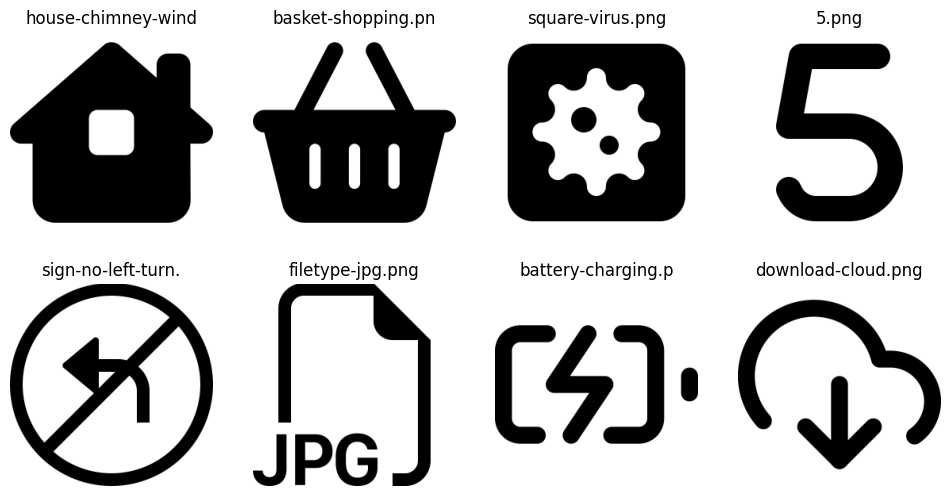

In [19]:
import matplotlib.pyplot as plt
import random

pngs = list(UNIQUE_DIR.glob("*.png"))
sample = random.sample(pngs, min(8, len(pngs)))

plt.figure(figsize=(12,6))
for i, path in enumerate(sample):
    img = Image.open(path)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(path.name[:18])
plt.show()
